   beta_win  entry_long  entry_short  exit_k  target_vol  sharpe_mean  \
0      7200         2.6          2.4     0.3        0.10    -9.816065   
1      7200         2.6          2.4     0.3        0.20    -9.816065   
2      7200         2.6          2.4     0.3        0.15    -9.816065   
3      3600         2.3          2.4     0.3        0.10   -11.998336   
4      3600         2.3          2.4     0.3        0.20   -11.998336   
5      3600         2.3          2.4     0.3        0.15   -11.998336   
6      3600         2.6          2.4     0.3        0.10   -12.299518   
7      3600         2.6          2.4     0.3        0.20   -12.299518   
8      3600         2.6          2.4     0.3        0.15   -12.299518   
9      7200         2.1          2.4     0.3        0.10   -12.755070   

   sharpe_med  sharpe_min  folds  
0   -8.172654  -16.323766      3  
1   -8.172654  -16.323766      3  
2   -8.172654  -16.323766      3  
3   -7.044421  -21.918469      3  
4   -7.044421  -21.91

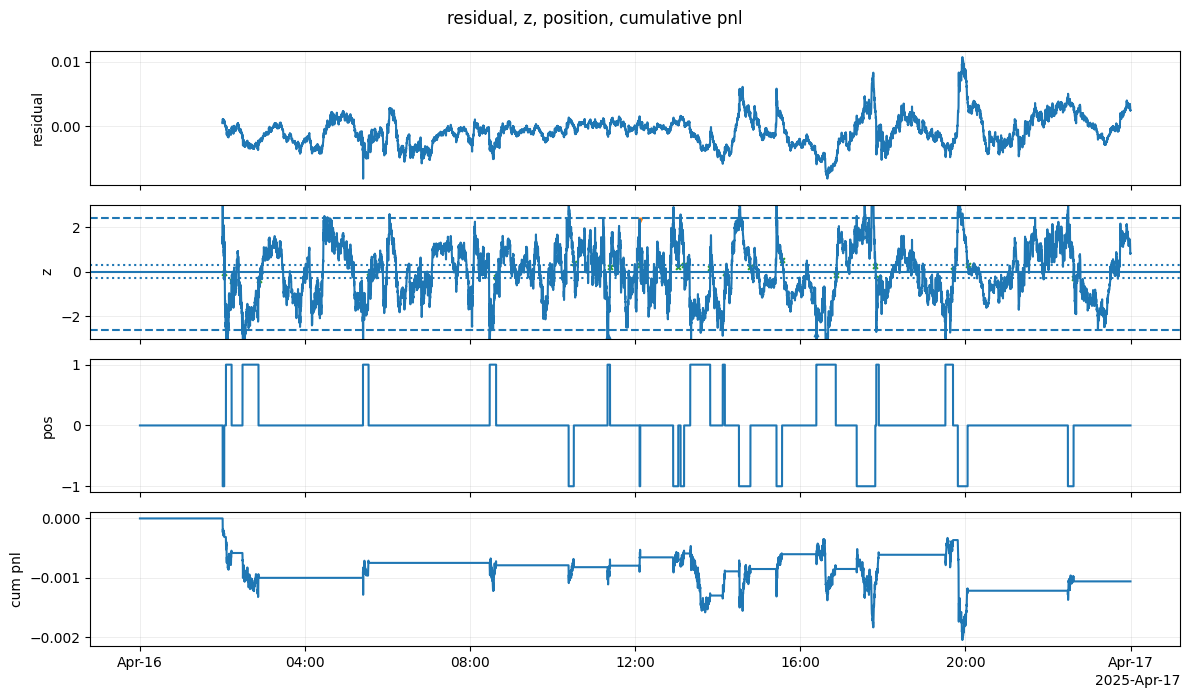

In [12]:
# params
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

TRADING_DAYS = 252
SECS_PER_DAY = 86400
TAKER_BPS = 1.2e-4
SPREAD_BPS = 0.8e-4
MAX_LEVERAGE = 5.0
MIN_WARMUP = 2500

# io
def _infer_epoch_unit(s):
    v = pd.to_numeric(s, errors="coerce").dropna()
    if v.empty: return "s"
    m = v.median()
    if m > 1e17: return "ns"
    if m > 1e14: return "us"
    if m > 1e11: return "ms"
    return "s"

def load_symbol_data(symbol):
    df = pd.read_csv(f"/Users/sean_tsu_/workPlan/data/{symbol}-1s-2025-04-16.csv", header=None)
    df.columns = ["open_time","open","high","low","close","volume","close_time","quote_volume","count","taker_buy_base_volume","taker_buy_quote_volume","blank"]
    unit = _infer_epoch_unit(df["open_time"])
    ts = pd.to_datetime(pd.to_numeric(df["open_time"], errors="coerce"), unit=unit, errors="coerce", utc=True)
    if ts.isna().all():
        unit = _infer_epoch_unit(df["close_time"])
        ts = pd.to_datetime(pd.to_numeric(df["close_time"], errors="coerce"), unit=unit, errors="coerce", utc=True)
    df = df.loc[ts.notna()].copy()
    df["ts"] = ts[ts.notna()]
    df = df.set_index("ts").sort_index()
    return df

df_btc = load_symbol_data("BTCUSDT")
df_eth = load_symbol_data("ETHUSDT")

# helpers
def _safe_shift(s, n=1):
    return s.shift(n).fillna(0.0)

def rolling_ols_beta_binance(x, y, window=3600):
    x_roll = x.rolling(window); y_roll = y.rolling(window)
    x_mean = x_roll.mean(); y_mean = y_roll.mean()
    cov_xy = (x*y).rolling(window).mean() - x_mean*y_mean
    var_x  = x_roll.var()
    b = (cov_xy / var_x).ffill()
    a = (y_mean - b * x_mean).ffill()
    return a, b

def half_life(eps):
    de = eps - eps.shift(1)
    num = (eps*de).mean()
    den = (eps**2).mean()
    phi = 1.0 + (num/den) if den and np.isfinite(den) else np.nan
    if not np.isfinite(phi) or phi >= 1.0: return 300.0
    if phi <= 0.0: return 50.0
    return float(max(10.0, min(3600.0, -1.0/np.log(phi))))

def zscore_ewm(s, halflife):
    mu = s.ewm(halflife=halflife, adjust=False).mean()
    var = (s - mu).ewm(halflife=halflife, adjust=False).var()
    return (s - mu) / np.sqrt(var)

def annualized_sharpe(rets, secs_per_bar, days=TRADING_DAYS):
    sd = rets.std()
    if not np.isfinite(sd) or sd == 0: return 0.0
    return np.sqrt(days * (SECS_PER_DAY / secs_per_bar)) * rets.mean() / sd

def hit_rate_from_series(gross, net):
    mask = net != 0
    if mask.sum() == 0: return np.nan
    return float((np.sign(gross[mask]) == np.sign(net[mask])).mean())

# backtest
def backtest_pair_binance(
    px_x, px_y,
    secs_per_bar=1,
    beta_win=3600,
    entry_k_long=2.3, entry_k_short=2.1,
    exit_k=0.4,
    stop_k=5.5,
    target_vol_annual=0.15,
    max_hold=3600,
    cost_buffer_k=0.25
):
    assert len(px_x) > MIN_WARMUP and len(px_y) > MIN_WARMUP
    x = np.log(px_x).rename("x"); y = np.log(px_y).rename("y")
    a_t, b_t = rolling_ols_beta_binance(x, y, beta_win)
    eps = (y - (a_t + b_t * x)).rename("eps")
    tau = half_life(eps.dropna())
    hl = max(30.0, min(6*3600.0, 3.0*tau))
    z = zscore_ewm(eps, hl).rename("z")
    e_pos = entry_k_short + cost_buffer_k
    e_neg = -entry_k_long - cost_buffer_k
    x_pos = exit_k
    x_neg = -exit_k
    s_pos = stop_k
    s_neg = -stop_k
    eps_ret = eps.diff()
    vol_eps = eps_ret.ewm(halflife=hl, adjust=False).std()
    ann_scale = np.sqrt(TRADING_DAYS * (SECS_PER_DAY / secs_per_bar))
    w = (target_vol_annual / (vol_eps * ann_scale)).clip(upper=MAX_LEVERAGE).fillna(0.0)
    pos = np.zeros(len(z)); hold = 0
    for i in range(1, len(z)):
        zi, zim1 = z.iloc[i], z.iloc[i-1]
        prev = pos[i-1]
        if prev > 0 and zi <= s_neg: prev = 0
        if prev < 0 and zi >= s_pos: prev = 0
        if (zim1 <= e_pos and zi > e_pos): prev, hold = -1.0, 0
        elif (zim1 >= e_neg and zi < e_neg): prev, hold = 1.0, 0
        if prev != 0:
            hold += 1
            if (prev>0 and zim1 <= x_neg and zi > x_neg) or (prev<0 and zim1 >= x_pos and zi < x_pos) or (hold >= max_hold):
                prev, hold = 0, 0
        pos[i] = prev
    position_sign = pd.Series(pos, index=z.index).rename("position_sign")
    notional = (position_sign * w).rename("notional")
    eps_ret = eps_ret.fillna(0.0)
    gross = (_safe_shift(notional, 1) * eps_ret).rename("gross")
    dnotional = (notional - notional.shift(1)).abs().fillna(notional.abs())
    legs_scale = (1.0 + b_t.abs()).fillna(1.0)
    per_trade_cost = (TAKER_BPS + SPREAD_BPS) * legs_scale
    costs = (dnotional * per_trade_cost).rename("costs")
    net = (gross - costs).fillna(0.0).rename("net")
    metrics = {
        "sharpe": annualized_sharpe(net, secs_per_bar),
        "turnover": float(dnotional.sum()),
        "hit_rate": hit_rate_from_series(gross, net),
        "hl": float(hl)
    }
    art = {"a": a_t, "b": b_t, "eps": eps, "z": z, "w": w, "position_sign": position_sign, "notional": notional, "gross": gross, "costs": costs, "net": net, "cum_pnl": net.cumsum()}
    return metrics, art

# grid
def walk_forward_grid_binance(
    px_x, px_y, secs_per_bar,
    beta_windows=(1800, 3600, 7200),
    entry_long=(2.1, 2.3, 2.6),
    entry_short=(1.9, 2.1, 2.4),
    exit_vals=(0.3, 0.4, 0.6),
    target_vols=(0.10, 0.15, 0.20),
    stop_k=6.0, folds=3
):
    n = len(px_x); edges = np.linspace(0, n, folds+1, dtype=int); rows = []
    for bw in beta_windows:
        for ekL in entry_long:
            for ekS in entry_short:
                for xk in exit_vals:
                    for tv in target_vols:
                        shard = []
                        for f in range(folds):
                            s, e = edges[f], edges[f+1]
                            px_x_f, px_y_f = px_x.iloc[s:e], px_y.iloc[s:e]
                            if len(px_x_f) < max(MIN_WARMUP, bw + 1000): continue
                            m, _ = backtest_pair_binance(px_x_f, px_y_f, secs_per_bar, bw, ekL, ekS, xk, stop_k, tv)
                            shard.append(m["sharpe"])
                        if shard:
                            rows.append({"beta_win": bw, "entry_long": ekL, "entry_short": ekS, "exit_k": xk, "target_vol": tv, "sharpe_mean": float(np.mean(shard)), "sharpe_med": float(np.median(shard)), "sharpe_min": float(np.min(shard)), "folds": len(shard)})
    return pd.DataFrame(rows).sort_values(["sharpe_mean","sharpe_med"], ascending=False).reset_index(drop=True)

# usage
secs_per_bar = 1
px_x = df_btc["close"].astype(float)
px_y = df_eth["close"].astype(float)
wf = walk_forward_grid_binance(px_x, px_y, secs_per_bar)
print(wf.head(10))
if not wf.empty:
    best = wf.iloc[0].to_dict()
    metrics, art = backtest_pair_binance(px_x, px_y, secs_per_bar, int(best["beta_win"]), float(best["entry_long"]), float(best["entry_short"]), float(best["exit_k"]), 6.0, float(best["target_vol"]))
else:
    metrics, art = backtest_pair_binance(px_x, px_y, secs_per_bar)
print("\nselected metrics:", metrics)

# plots
def plot_pair(art, best=None, resample_rule="5s"):
    def _r(s):
        if isinstance(s.index, pd.DatetimeIndex) and resample_rule:
            rule = resample_rule.lower() if isinstance(resample_rule, str) else resample_rule
            try: return s.resample(rule).mean()
            except: return s
        return s
    eps = _r(art["eps"]); z = _r(art["z"]); pnl = _r(art["cum_pnl"]); pos = _r(art["position_sign"].astype(float))
    ekL = float(best["entry_long"]) if best and "entry_long" in best else 2.3
    ekS = float(best["entry_short"]) if best and "entry_short" in best else 2.1
    xk  = float(best["exit_k"]) if best and "exit_k" in best else 0.4
    entries_long  = (pos ==  1) & (pos.shift(1) == 0)
    entries_short = (pos == -1) & (pos.shift(1) == 0)
    exits         = (pos ==  0) & (pos.shift(1) != 0)
    use_dates = isinstance(eps.index, pd.DatetimeIndex)
    if use_dates:
        loc = mdates.AutoDateLocator(minticks=3, maxticks=8)
        fmt = mdates.ConciseDateFormatter(loc)
    zlim = np.nanpercentile(np.abs(z.values), 99) if np.isfinite(z.values).any() else 3.0
    zlim = float(max(3.0, min(10.0, np.ceil(zlim))))
    fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)
    axes[0].plot(eps); axes[0].set_ylabel("residual"); axes[0].grid(True, alpha=0.3, linewidth=0.5)
    axes[1].plot(z); axes[1].axhline(0.0, linestyle="-")
    axes[1].axhline( ekS, linestyle="--"); axes[1].axhline(-ekL, linestyle="--")
    axes[1].axhline( xk, linestyle=":");  axes[1].axhline(-xk,  linestyle=":")
    axes[1].scatter(z.index[entries_long],  z[entries_long],  s=10, marker="^")
    axes[1].scatter(z.index[entries_short], z[entries_short], s=10, marker="v")
    axes[1].scatter(z.index[exits],         z[exits],         s=12, marker="x")
    axes[1].set_ylim(-zlim, zlim); axes[1].set_ylabel("z"); axes[1].grid(True, alpha=0.3, linewidth=0.5)
    axes[2].step(pos.index, pos, where="post"); axes[2].set_ylabel("pos"); axes[2].set_yticks([-1, 0, 1]); axes[2].grid(True, alpha=0.3, linewidth=0.5)
    axes[3].plot(pnl); axes[3].set_ylabel("cum pnl"); axes[3].grid(True, alpha=0.3, linewidth=0.5)
    if use_dates:
        for ax in axes:
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(fmt)
    fig.suptitle("residual, z, position, cumulative pnl", y=0.99)
    fig.tight_layout(); plt.show()

best_dict = best if 'best' in globals() and isinstance(best, dict) else None
plot_pair(art, best=best_dict, resample_rule="5s")


   beta_win  entry_long  entry_short  exit_k  target_vol  sharpe_mean  \
0      7200         2.6          2.4     0.3        0.10    -9.816065   
1      7200         2.6          2.4     0.3        0.20    -9.816065   
2      7200         2.6          2.4     0.3        0.15    -9.816065   
3      3600         2.3          2.4     0.3        0.10   -11.998336   
4      3600         2.3          2.4     0.3        0.20   -11.998336   
5      3600         2.3          2.4     0.3        0.15   -11.998336   
6      3600         2.6          2.4     0.3        0.10   -12.299518   
7      3600         2.6          2.4     0.3        0.20   -12.299518   
8      3600         2.6          2.4     0.3        0.15   -12.299518   
9      7200         2.1          2.4     0.3        0.10   -12.755070   

   sharpe_med  sharpe_min  folds  
0   -8.172654  -16.323766      3  
1   -8.172654  -16.323766      3  
2   -8.172654  -16.323766      3  
3   -7.044421  -21.918469      3  
4   -7.044421  -21.91

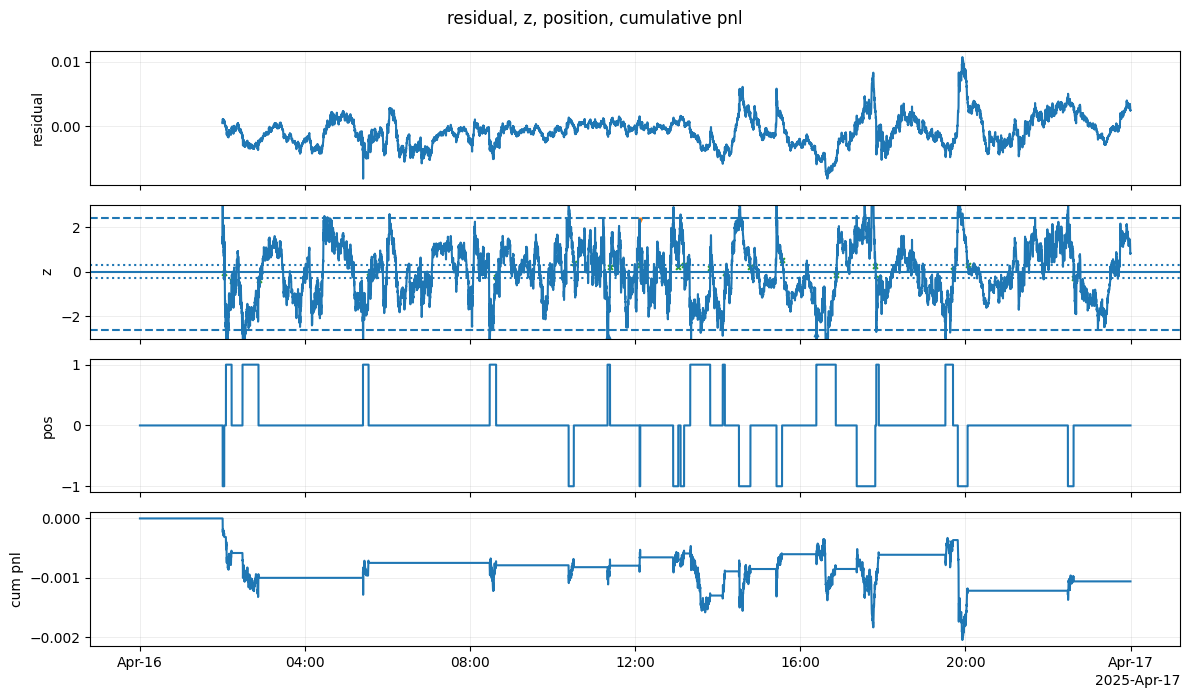

In [13]:
# params
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

TRADING_DAYS = 252
SECS_PER_DAY = 86400
TAKER_BPS = 1.2e-4
SPREAD_BPS = 0.8e-4
MAX_LEVERAGE = 5.0
MIN_WARMUP = 2500

# helpers
def _infer_epoch_unit(s):
    v = pd.to_numeric(s, errors="coerce").dropna()
    if v.empty: return "s"
    m = v.median()
    if m > 1e17: return "ns"
    if m > 1e14: return "us"
    if m > 1e11: return "ms"
    return "s"

def ensure_time_index(df):
    if isinstance(df.index, pd.DatetimeIndex):
        return df.sort_index()
    for col in ["open_time","close_time"]:
        if col in df.columns:
            unit = _infer_epoch_unit(df[col])
            ts = pd.to_datetime(pd.to_numeric(df[col], errors="coerce"), unit=unit, errors="coerce", utc=True)
            if ts.notna().any():
                out = df.loc[ts.notna()].copy()
                out["ts"] = ts[ts.notna()]
                return out.set_index("ts").sort_index()
    return df

def _safe_shift(s, n=1):
    return s.shift(n).fillna(0.0)

def rolling_ols_beta_binance(x, y, window=3600):
    x_roll = x.rolling(window); y_roll = y.rolling(window)
    x_mean = x_roll.mean(); y_mean = y_roll.mean()
    cov_xy = (x*y).rolling(window).mean() - x_mean*y_mean
    var_x  = x_roll.var()
    b = (cov_xy / var_x).ffill()
    a = (y_mean - b * x_mean).ffill()
    return a, b

def half_life(eps):
    de = eps - eps.shift(1)
    num = (eps*de).mean()
    den = (eps**2).mean()
    phi = 1.0 + (num/den) if den and np.isfinite(den) else np.nan
    if not np.isfinite(phi) or phi >= 1.0: return 300.0
    if phi <= 0.0: return 50.0
    return float(max(10.0, min(3600.0, -1.0/np.log(phi))))

def zscore_ewm(s, halflife):
    mu = s.ewm(halflife=halflife, adjust=False).mean()
    var = (s - mu).ewm(halflife=halflife, adjust=False).var()
    return (s - mu) / np.sqrt(var)

def annualized_sharpe(rets, secs_per_bar, days=TRADING_DAYS):
    sd = rets.std()
    if not np.isfinite(sd) or sd == 0: return 0.0
    return np.sqrt(days * (SECS_PER_DAY / secs_per_bar)) * rets.mean() / sd

def hit_rate_from_series(gross, net):
    mask = net != 0
    if mask.sum() == 0: return np.nan
    return float((np.sign(gross[mask]) == np.sign(net[mask])).mean())

# backtest
def backtest_pair_binance(
    px_x, px_y,
    secs_per_bar=1,
    beta_win=3600,
    entry_k_long=2.3, entry_k_short=2.1,
    exit_k=0.4,
    stop_k=5.5,
    target_vol_annual=0.15,
    max_hold=3600,
    cost_buffer_k=0.25
):
    assert len(px_x) > MIN_WARMUP and len(px_y) > MIN_WARMUP
    x = np.log(px_x).rename("x"); y = np.log(px_y).rename("y")
    a_t, b_t = rolling_ols_beta_binance(x, y, beta_win)
    eps = (y - (a_t + b_t * x)).rename("eps")
    tau = half_life(eps.dropna())
    hl = max(30.0, min(6*3600.0, 3.0*tau))
    z = zscore_ewm(eps, hl).rename("z")
    e_pos = entry_k_short + cost_buffer_k
    e_neg = -entry_k_long - cost_buffer_k
    x_pos = exit_k
    x_neg = -exit_k
    s_pos = stop_k
    s_neg = -stop_k
    eps_ret = eps.diff()
    vol_eps = eps_ret.ewm(halflife=hl, adjust=False).std()
    ann_scale = np.sqrt(TRADING_DAYS * (SECS_PER_DAY / secs_per_bar))
    w = (target_vol_annual / (vol_eps * ann_scale)).clip(upper=MAX_LEVERAGE).fillna(0.0)
    pos = np.zeros(len(z)); hold = 0
    for i in range(1, len(z)):
        zi, zim1 = z.iloc[i], z.iloc[i-1]
        prev = pos[i-1]
        if prev > 0 and zi <= s_neg: prev = 0
        if prev < 0 and zi >= s_pos: prev = 0
        if (zim1 <= e_pos and zi > e_pos): prev, hold = -1.0, 0
        elif (zim1 >= e_neg and zi < e_neg): prev, hold = 1.0, 0
        if prev != 0:
            hold += 1
            if (prev>0 and zim1 <= x_neg and zi > x_neg) or (prev<0 and zim1 >= x_pos and zi < x_pos) or (hold >= max_hold):
                prev, hold = 0, 0
        pos[i] = prev
    position_sign = pd.Series(pos, index=z.index).rename("position_sign")
    notional = (position_sign * w).rename("notional")
    eps_ret = eps_ret.fillna(0.0)
    gross = (_safe_shift(notional, 1) * eps_ret).rename("gross")
    dnotional = (notional - notional.shift(1)).abs().fillna(notional.abs())
    legs_scale = (1.0 + b_t.abs()).fillna(1.0)
    per_trade_cost = (TAKER_BPS + SPREAD_BPS) * legs_scale
    costs = (dnotional * per_trade_cost).rename("costs")
    net = (gross - costs).fillna(0.0).rename("net")
    metrics = {
        "sharpe": annualized_sharpe(net, secs_per_bar),
        "turnover": float(dnotional.sum()),
        "hit_rate": hit_rate_from_series(gross, net),
        "hl": float(hl)
    }
    art = {"a": a_t, "b": b_t, "eps": eps, "z": z, "w": w, "position_sign": position_sign, "notional": notional, "gross": gross, "costs": costs, "net": net, "cum_pnl": net.cumsum()}
    return metrics, art

# grid
def walk_forward_grid_binance(
    px_x, px_y, secs_per_bar,
    beta_windows=(1800, 3600, 7200),
    entry_long=(2.1, 2.3, 2.6),
    entry_short=(1.9, 2.1, 2.4),
    exit_vals=(0.3, 0.4, 0.6),
    target_vols=(0.10, 0.15, 0.20),
    stop_k=6.0, folds=3
):
    n = len(px_x); edges = np.linspace(0, n, folds+1, dtype=int); rows = []
    for bw in beta_windows:
        for ekL in entry_long:
            for ekS in entry_short:
                for xk in exit_vals:
                    for tv in target_vols:
                        shard = []
                        for f in range(folds):
                            s, e = edges[f], edges[f+1]
                            px_x_f, px_y_f = px_x.iloc[s:e], px_y.iloc[s:e]
                            if len(px_x_f) < max(MIN_WARMUP, bw + 1000): continue
                            m, _ = backtest_pair_binance(px_x_f, px_y_f, secs_per_bar, bw, ekL, ekS, xk, stop_k, tv)
                            shard.append(m["sharpe"])
                        if shard:
                            rows.append({"beta_win": bw, "entry_long": ekL, "entry_short": ekS, "exit_k": xk, "target_vol": tv, "sharpe_mean": float(np.mean(shard)), "sharpe_med": float(np.median(shard)), "sharpe_min": float(np.min(shard)), "folds": len(shard)})
    return pd.DataFrame(rows).sort_values(["sharpe_mean","sharpe_med"], ascending=False).reset_index(drop=True)

# application
df_BTC = ensure_time_index(df_BTC) if 'df_BTC' in globals() else None
df_ETH = ensure_time_index(df_ETH) if 'df_ETH' in globals() else None
secs_per_bar = 1
px_x = df_BTC["close"].astype(float)
px_y = df_ETH["close"].astype(float)
wf = walk_forward_grid_binance(px_x, px_y, secs_per_bar)
print(wf.head(10))
if not wf.empty:
    best = wf.iloc[0].to_dict()
    metrics, art = backtest_pair_binance(px_x, px_y, secs_per_bar, int(best["beta_win"]), float(best["entry_long"]), float(best["entry_short"]), float(best["exit_k"]), 6.0, float(best["target_vol"]))
else:
    metrics, art = backtest_pair_binance(px_x, px_y, secs_per_bar)
print("\nselected metrics:", metrics)

# plots
def plot_pair(art, best=None, resample_rule="5s"):
    def _r(s):
        if isinstance(s.index, pd.DatetimeIndex) and resample_rule:
            rule = resample_rule.lower() if isinstance(resample_rule, str) else resample_rule
            try: return s.resample(rule).mean()
            except: return s
        return s
    eps = _r(art["eps"]); z = _r(art["z"]); pnl = _r(art["cum_pnl"]); pos = _r(art["position_sign"].astype(float))
    ekL = float(best["entry_long"]) if best and "entry_long" in best else 2.3
    ekS = float(best["entry_short"]) if best and "entry_short" in best else 2.1
    xk  = float(best["exit_k"]) if best and "exit_k" in best else 0.4
    entries_long  = (pos ==  1) & (pos.shift(1) == 0)
    entries_short = (pos == -1) & (pos.shift(1) == 0)
    exits         = (pos ==  0) & (pos.shift(1) != 0)
    use_dates = isinstance(eps.index, pd.DatetimeIndex)
    if use_dates:
        loc = mdates.AutoDateLocator(minticks=3, maxticks=8)
        fmt = mdates.ConciseDateFormatter(loc)
    zlim = np.nanpercentile(np.abs(z.values), 99) if np.isfinite(z.values).any() else 3.0
    zlim = float(max(3.0, min(10.0, np.ceil(zlim))))
    fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)
    axes[0].plot(eps); axes[0].set_ylabel("residual"); axes[0].grid(True, alpha=0.3, linewidth=0.5)
    axes[1].plot(z); axes[1].axhline(0.0, linestyle="-")
    axes[1].axhline( ekS, linestyle="--"); axes[1].axhline(-ekL, linestyle="--")
    axes[1].axhline( xk, linestyle=":");  axes[1].axhline(-xk,  linestyle=":")
    axes[1].scatter(z.index[entries_long],  z[entries_long],  s=10, marker="^")
    axes[1].scatter(z.index[entries_short], z[entries_short], s=10, marker="v")
    axes[1].scatter(z.index[exits],         z[exits],         s=12, marker="x")
    axes[1].set_ylim(-zlim, zlim); axes[1].set_ylabel("z"); axes[1].grid(True, alpha=0.3, linewidth=0.5)
    axes[2].step(pos.index, pos, where="post"); axes[2].set_ylabel("pos"); axes[2].set_yticks([-1, 0, 1]); axes[2].grid(True, alpha=0.3, linewidth=0.5)
    axes[3].plot(pnl); axes[3].set_ylabel("cum pnl"); axes[3].grid(True, alpha=0.3, linewidth=0.5)
    if use_dates:
        for ax in axes:
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(fmt)
    fig.suptitle("residual, z, position, cumulative pnl", y=0.99)
    fig.tight_layout(); plt.show()

best_dict = best if 'best' in globals() and isinstance(best, dict) else None
plot_pair(art, best=best_dict, resample_rule="5s")
